<center><h1>Hyper Parameter Tuning</h1></center>

<h2>Importing Libraries</h2>

In [105]:
import pandas as pd
import numpy as np
import time
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

<h2>Importing Feature Sets</h2>

In [90]:
X_train = pd.read_csv("../Final Feature Sets/X_train.csv")
X_test = pd.read_csv("../Final Feature Sets/X_test.csv")
y_train = pd.read_csv("../Final Feature Sets/y_train.csv")['activity_code'] - 1
y_test = pd.read_csv("../Final Feature Sets/y_test.csv")['activity_code'] - 1
research_X_train = pd.read_csv("../Final Feature Sets/feature_reduced_X_train.csv")
research_X_test = pd.read_csv("../Final Feature Sets/feature_reduced_X_test.csv")
rf_efficent_X_train = pd.read_csv("../Final Feature Sets/rf_most_efficent_train.csv")
rf_efficent_X_test = pd.read_csv("../Final Feature Sets/rf_most_efficent_test.csv")
xgb_accurate_X_train = pd.read_csv("../Final Feature Sets/xgb_most_accurate_train.csv")
xgb_accurate_X_test = pd.read_csv("../Final Feature Sets/xgb_most_accurate_test.csv")

Making all the feature sets available in a single dictionary, so that we can find the feature sets at one place for hyper paramter tuning.

In [52]:
feature_sets = {
    "All Features" : (X_train, y_train),
    "Research Features" : (research_X_train, y_train),
    "RF Efficent" : (rf_efficent_X_train, y_train),
    "XGB Accurate" : (xgb_accurate_X_train, y_train)
}

<h3>BaseLine Re-Establishment</h3>

The main reason we are doing this is because we are going to use only 3-fold cv, since 5-fold is going to be too much and also the evaluation metric will be based on just f1_macro, instead of both accuracy and f1_macro.

In [56]:
def baseline_evaluation_3fold(feature_sets):
    
    """
   Evaluates baseline XGBoost performance across multiple feature sets using 3-fold cross-validation.
   
   Args:
       feature_sets: Dictionary of feature sets in format {name: (X_data, y_data)}
       
   Returns:
       dict: Baseline performance metrics (F1-macro mean and standard deviation) for each feature set
   """
    
    baseline_results = {}
    
    for fs_name, (X_data, y_data) in feature_sets.items():
        print(f"Baseline evaluation for {fs_name} ({X_data.shape[1]} features)")
        
        xgb_baseline = XGBClassifier(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1, 
            eval_metric='mlogloss'
        )
        
        cv_scores = cross_validate(
            xgb_baseline,
            X_data,
            y_data,
            cv=3,
            scoring='f1_macro',
            return_train_score=False
        )
        
        baseline_f1 = cv_scores['test_score'].mean()
        baseline_std = cv_scores['test_score'].std()
        
        baseline_results[fs_name] = {
            'baseline_f1': baseline_f1,
            'baseline_std': baseline_std
        }
        
        print(f"Baseline F1 (3-fold): {baseline_f1:.4f} ± {baseline_std:.4f}")
        print()
        
    return baseline_results

In [57]:
baseline_3fold_results = baseline_evaluation_3fold(feature_sets)

Baseline evaluation for All Features (561 features)
Baseline F1 (3-fold): 0.9069 ± 0.0285

Baseline evaluation for Research Features (66 features)
Baseline F1 (3-fold): 0.8925 ± 0.0354

Baseline evaluation for RF Efficent (26 features)
Baseline F1 (3-fold): 0.8861 ± 0.0216

Baseline evaluation for XGB Accurate (54 features)
Baseline F1 (3-fold): 0.8954 ± 0.0283



<h3>We are going to be using a 2-stage approach by using RandomizedSearch and GridSearch</h3> 

<ul>
    <li><b>Stage 1: </b>We are going to be RandomizedSearch, which helps us explore wide range of parameters efficently, while the computational cost will be adjusted as per our needs based on the n_iter parameter. This helps us narrow out the paramters that work good.</li>
    <li><b>Stage 2: </b>Here we use GridSearch, which helps us explore around the resultant good parameters from RandomizedSearch. This ensures that the good paramters will be further revised to produce the best parameters for our model.</li>
</ul>

In [42]:
xgb_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.29),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2)
}

<h3>Performing RandomizedSearch on all the 4 feature sets</h3>

We are going to be implementing RandomizedSearch on all the feature sets for a range of paramters to get the optimal ones.

In [53]:
def optimize_xgboost_randomized(feature_sets_dict, param_dist, n_iter=100):
    
    """
   Performs RandomizedSearchCV hyperparameter optimization on XGBoost across multiple feature sets.
   
   Args:
       feature_sets_dict: Dictionary of feature sets in format {name: (X_data, y_data)}
       param_dist: Parameter distributions for randomized search
       n_iter: Number of parameter combinations to test per feature set
       
   Returns:
       dict: Optimization results containing best estimator, parameters, scores, and timing for each feature set
   """
    
    results = {}
    
    for fs_name, (X_data, y_data) in feature_sets_dict.items():  # Unpack tuple
        print(f"Starting RandomizedSearch for XGBoost on {fs_name} ({X_data.shape[1]} features)")
        
        xgb_model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
        
        random_search = RandomizedSearchCV(
            estimator=xgb_model,
            param_distributions=param_dist,
            n_iter=n_iter,
            cv=3,
            scoring='f1_macro',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        
        start_time = time.time()
        random_search.fit(X_data, y_data)  
        optimization_time = time.time() - start_time
        
        results[fs_name] = {
            'best_estimator': random_search.best_estimator_,
            'best_params': random_search.best_params_,
            'best_score': random_search.best_score_,
            'optimization_time': optimization_time
        }
        
        print(f"Completed {fs_name}: Best CV F1 = {random_search.best_score_:.4f}")
        print(f"Best params: {random_search.best_params_}")
        print(f"Time: {optimization_time:.1f} seconds\n")
    
    return results

So now the function is written, we can go ahead and call it and view the optimal parameters found by RandomizedSearch for each feature set.

In [54]:
xgb_random_results = optimize_xgboost_randomized(feature_sets, xgb_param_dist)

Starting RandomizedSearch for XGBoost on All Features (561 features)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Completed All Features: Best CV F1 = 0.9225
Best params: {'colsample_bytree': 0.7223651931039312, 'learning_rate': 0.29619721161415, 'max_depth': 3, 'n_estimators': 235, 'reg_alpha': 0.005522117123602399, 'reg_lambda': 1.6309228569096683, 'subsample': 0.9120572031542851}
Time: 1937.3 seconds

Starting RandomizedSearch for XGBoost on Research Features (66 features)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Completed Research Features: Best CV F1 = 0.9075
Best params: {'colsample_bytree': 0.865476361763221, 'learning_rate': 0.057801935729730275, 'max_depth': 3, 'n_estimators': 473, 'reg_alpha': 0.8105533307818329, 'reg_lambda': 1.974552258629889, 'subsample': 0.7451250673310584}
Time: 271.4 seconds

Starting RandomizedSearch for XGBoost on RF Efficent (26 features)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Completed 

<h3>Comparision with baseline</h3>

In [63]:
for fs_name in feature_sets.keys():
    optimized_f1 = xgb_random_results[fs_name]['best_score']
    baseline_f1 = baseline_3fold_results[fs_name]['baseline_f1']
    improvement = optimized_f1 - baseline_f1
    print(f"Feature set {fs_name}")
    print(f"Baseline F1: {baseline_f1:.4f}")
    print(f"Optimized F1: {optimized_f1:.4f}")
    print(f"Improvement: {improvement:+.4f}\n")

Feature set All Features
Baseline F1: 0.9069
Optimized F1: 0.9225
Improvement: +0.0156

Feature set Research Features
Baseline F1: 0.8925
Optimized F1: 0.9075
Improvement: +0.0150

Feature set RF Efficent
Baseline F1: 0.8861
Optimized F1: 0.8961
Improvement: +0.0100

Feature set XGB Accurate
Baseline F1: 0.8954
Optimized F1: 0.9169
Improvement: +0.0215



We can see that there has been an increase in atleast 1-2.15 percent from the baseline model with default parameters to parameters tuned for each model.

<h3>Grid Optimization for GridSearch</h3>

We have got good increase in f1_macro score, but let us just do some further refinement just to make sure we have the true optimal parameters.

But before we GridSearch, the paramters obtained from RandomizedSearch are different for each model. In GridSearch, we are not going to search far away from the optimal paramters already obtained, so we have to have different set of parameters for each model for GridSearch.

So we will write a function that gets the best parameters for each feature set and searches 0.9, 1.1 additional values to see if the models can get any better.

In [77]:
def create_refined_grids(xgb_random_results):
    
    """
   Creates refined parameter grids for GridSearchCV based on RandomizedSearchCV best parameters.
   
   Args:
       xgb_random_results: Dictionary containing RandomizedSearchCV results with best parameters
       
   Returns:
       dict: Refined parameter grids with conservative ranges (±10%) around optimal values for each feature set
   """
    
    refined_grids = {}
    
    for fs_name, results in xgb_random_results.items():
        best_params = results['best_params']
        
        best_lr = best_params['learning_rate']
        best_depth = best_params['max_depth'] 
        best_n_est = best_params['n_estimators']
        
        # 
        depth_values = list(set([max(3, best_depth - 1), best_depth, min(8, best_depth + 1)]))
        depth_values.sort()  
        
        refined_grids[fs_name] = {
            'learning_rate': [best_lr * 0.9, best_lr, best_lr * 1.1],
            'max_depth': depth_values,  # Only unique values
            'n_estimators': [int(best_n_est * 0.9), best_n_est, int(best_n_est * 1.1)]
        }
    
    return refined_grids

In [78]:
refined_grids = create_refined_grids(xgb_random_results)

We are going to implement GridSearch just like we implemented RandomizedSearch and see how the results will look like.

In [79]:
def optimize_xgboost_gridsearch(feature_sets, refined_grids):
    
    """
   Performs GridSearchCV refinement using focused parameter grids around previously identified optimal values.
   
   Args:
       feature_sets: Dictionary of feature sets in format {name: (X_data, y_data)}
       refined_grids: Dictionary of refined parameter grids for each feature set
       
   Returns:
       dict: Grid search results containing best estimator, parameters, scores, and timing for each feature set
   """
    
    grid_results = {}
    
    for fs_name, (X_data, y_data) in feature_sets.items():
        print(f"GridSearch refinement for {fs_name} ({X_data.shape[1]} features)")
        
        xgb_model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
        
        grid_search = GridSearchCV(
            estimator=xgb_model,
            param_grid=refined_grids[fs_name],
            cv=3,
            scoring='f1_macro',
            n_jobs=-1,
            verbose=1
        )
        
        start_time = time.time()
        grid_search.fit(X_data, y_data)
        optimization_time = time.time() - start_time
        
        grid_results[fs_name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'optimization_time': optimization_time
        }
        
        print(f"Completed {fs_name}: Best CV F1 = {grid_search.best_score_:.4f}")
        print(f"Time: {optimization_time:.1f} seconds\n")
    
    return grid_results

In [82]:
grid_results = optimize_xgboost_gridsearch(feature_sets, refined_grids)

GridSearch refinement for All Features (561 features)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Completed All Features: Best CV F1 = 0.9204
Time: 160.5 seconds

GridSearch refinement for Research Features (66 features)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Completed Research Features: Best CV F1 = 0.9010
Time: 105.9 seconds

GridSearch refinement for RF Efficent (26 features)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Completed RF Efficent: Best CV F1 = 0.8976
Time: 8.5 seconds

GridSearch refinement for XGB Accurate (54 features)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Completed XGB Accurate: Best CV F1 = 0.9139
Time: 11.8 seconds



So the inference would be to stick with the RandomizedSearch parameters as the final parameters, since GridSearch did not yield better results that RandomizedSearch.

<h3>Training models on optimal parameters for each feature set</h3>

Before we head to our final testing, we train the models on their respective best parameters and get them ready for final testing on the testing set.

In [85]:
def train_optimized_models(feature_sets, xgb_random_results):
    
    """
   Trains final XGBoost models using optimal hyperparameters on complete training datasets.
   
   Args:
       feature_sets: Dictionary of feature sets in format {name: (X_data, y_data)}
       xgb_random_results: Dictionary containing optimal parameters from RandomizedSearchCV
       
   Returns:
       dict: Trained models with metadata including parameters, training time, and feature count
   """
    
    trained_models = {}
    
    for fs_name, (X_train, y_train) in feature_sets.items():
        print(f"Training optimized model for {fs_name} ({X_train.shape[1]} features)")
        
        best_params = xgb_random_results[fs_name]['best_params']
        
        optimized_model = XGBClassifier(
            **best_params,
            random_state=42,
            n_jobs=-1,
            eval_metric='mlogloss'
        )
        
        start_time = time.time()
        optimized_model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        trained_models[fs_name] = {
            'model': optimized_model,
            'best_params': best_params,
            'training_time': training_time,
            'num_features': X_train.shape[1]
        }
        
        print(f"Training completed in {training_time:.1f} seconds")
        print(f"Model parameters: {best_params}")
        print()
    
    return trained_models

In [86]:
final_trained_models = train_optimized_models(feature_sets, xgb_random_results)

Training optimized model for All Features (561 features)
Training completed in 8.2 seconds
Model parameters: {'colsample_bytree': 0.7223651931039312, 'learning_rate': 0.29619721161415, 'max_depth': 3, 'n_estimators': 235, 'reg_alpha': 0.005522117123602399, 'reg_lambda': 1.6309228569096683, 'subsample': 0.9120572031542851}

Training optimized model for Research Features (66 features)
Training completed in 3.3 seconds
Model parameters: {'colsample_bytree': 0.865476361763221, 'learning_rate': 0.057801935729730275, 'max_depth': 3, 'n_estimators': 473, 'reg_alpha': 0.8105533307818329, 'reg_lambda': 1.974552258629889, 'subsample': 0.7451250673310584}

Training optimized model for RF Efficent (26 features)
Training completed in 0.4 seconds
Model parameters: {'colsample_bytree': 0.925712358831304, 'learning_rate': 0.23955792268049605, 'max_depth': 3, 'n_estimators': 138, 'reg_alpha': 0.09120610304869037, 'reg_lambda': 0.9888406094051629, 'subsample': 0.7172676280049932}

Training optimized mod

The models are trained, now let us create a testing sets dictionary.

In [99]:
test_feature_sets = {
    "All Features" : (X_test, y_test),
    "Research Features" : (research_X_test, y_test),
    "RF Efficent" : (rf_efficent_X_test, y_test),
    "XGB Accurate" : (xgb_accurate_X_test, y_test)
}

So here comes the final part we have been waiting for, the models showdown (althought we know which the most accurate model is going to be). Let the drumroll begin to see the final performance.

In [103]:
def evaluate_final_models(trained_models, test_sets):
    
    """
   Evaluates trained models on test sets and calculates comprehensive performance metrics.
   
   Args:
       trained_models: Dictionary of trained models with metadata
       test_sets: Dictionary of test sets in format {name: (X_test, y_test)}
       
   Returns:
       dict: Test performance metrics including accuracy, F1-score, efficiency score, and inference timing
   """
    
    test_results = {}
    
    for fs_name, model_info in trained_models.items():
        print(f"Evaluating {fs_name} on test set ({model_info['num_features']} features)")
        
        model = model_info['model']
        
        X_test, y_test = test_sets[fs_name]
        
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time
        
        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='macro')
        efficiency_score = (test_accuracy * test_f1 * 1000) / model_info['num_features']
        
        test_results[fs_name] = {
            'test_accuracy': test_accuracy,
            'test_f1': test_f1,
            'efficiency_score': efficiency_score,
            'inference_time': inference_time,
            'num_features': model_info['num_features'],
            'best_params': model_info['best_params']
        }
        
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test F1-macro: {test_f1:.4f}")
        print(f"Efficiency Score: {efficiency_score:.2f}")
        print(f"Inference Time: {inference_time:.4f}s")
        print()
    
    return test_results

<h3>Final Results</h3>

In [104]:
final_test_results = evaluate_final_models(final_trained_models, test_feature_sets)

Evaluating All Features on test set (561 features)
Test Accuracy: 0.9572
Test F1-macro: 0.9569
Efficiency Score: 1.63
Inference Time: 0.0796s

Evaluating Research Features on test set (66 features)
Test Accuracy: 0.9240
Test F1-macro: 0.9224
Efficiency Score: 12.91
Inference Time: 0.0160s

Evaluating RF Efficent on test set (26 features)
Test Accuracy: 0.9152
Test F1-macro: 0.9140
Efficiency Score: 32.17
Inference Time: 0.0054s

Evaluating XGB Accurate on test set (54 features)
Test Accuracy: 0.9203
Test F1-macro: 0.9189
Efficiency Score: 15.66
Inference Time: 0.0094s



<h3>Observations</h3>

<ul>
    <li><b>Most Accurate Feature Set: </b>The best feature set with the highest accuracy is the one containing all the features as expected with an accuracy of almost 96 percent on the testing set.</li>
    <li><b>Research Feature Set: </b>Althought it is not the best performing set during training it generalized well on the testing set with just around 3 percent decrease in accuracy compared to 88% reduction in features.</li>
    <li><b>XGB Accurate Dataset: </b>This is the feature set with the second highest accuracy (92%) with over 90% reduction in features.</li>
    <li><b>RandomForest Efficent Dataset: </b>With over 95% reduction in features and over 91% in accuracy, it is safe to say that it is the most efficent model in our arsenal. This model is just under 19.7 times more efficent than the All Feature set model</li>
</ul>

<h3>Confusion Matrices</h3>

One of the most important aspect would be to know what categories our models go the most confused on, so we can cross check it with if human's identification accuracy to say if we can still improve the model or not.

In [108]:
def create_confusion_matrices(trained_models, test_sets, test_results):
    
    """
   Generates confusion matrices for all trained models to analyze prediction errors and per-class performance.
   
   Args:
       trained_models: Dictionary of trained models with metadata
       test_sets: Dictionary of test sets in format {name: (X_test, y_test)}
       test_results: Dictionary containing test performance metrics
       
   Returns:
       None: Displays visualization and prints per-class accuracy metrics
   """
    
    activity_labels = ['Walking', 'Walking_Upstairs', 'Walking_Downstairs', 
                      'Sitting', 'Standing', 'Laying']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, (fs_name, model_info) in enumerate(trained_models.items()):
        model = model_info['model']
        X_test, y_test = test_sets[fs_name]
        
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        
        accuracy = test_results[fs_name]['test_accuracy']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=activity_labels,
                   yticklabels=activity_labels,
                   ax=axes[idx])
        
        axes[idx].set_title(f'{fs_name}\nAccuracy: {accuracy:.3f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        
        class_accuracy = cm.diagonal() / cm.sum(axis=1)
        print(f"\n{fs_name} - Per-class accuracy:")
        for i, activity in enumerate(activity_labels):
            print(f"  {activity}: {class_accuracy[i]:.3f}")
    
    plt.tight_layout()
    plt.show()


All Features - Per-class accuracy:
  Walking: 0.984
  Walking_Upstairs: 0.955
  Walking_Downstairs: 0.948
  Sitting: 0.886
  Standing: 0.964
  Laying: 1.000

Research Features - Per-class accuracy:
  Walking: 0.933
  Walking_Upstairs: 0.898
  Walking_Downstairs: 0.888
  Sitting: 0.876
  Standing: 0.934
  Laying: 1.000

RF Efficent - Per-class accuracy:
  Walking: 0.988
  Walking_Upstairs: 0.879
  Walking_Downstairs: 0.886
  Sitting: 0.792
  Standing: 0.930
  Laying: 1.000

XGB Accurate - Per-class accuracy:
  Walking: 0.986
  Walking_Upstairs: 0.890
  Walking_Downstairs: 0.886
  Sitting: 0.792
  Standing: 0.951
  Laying: 1.000


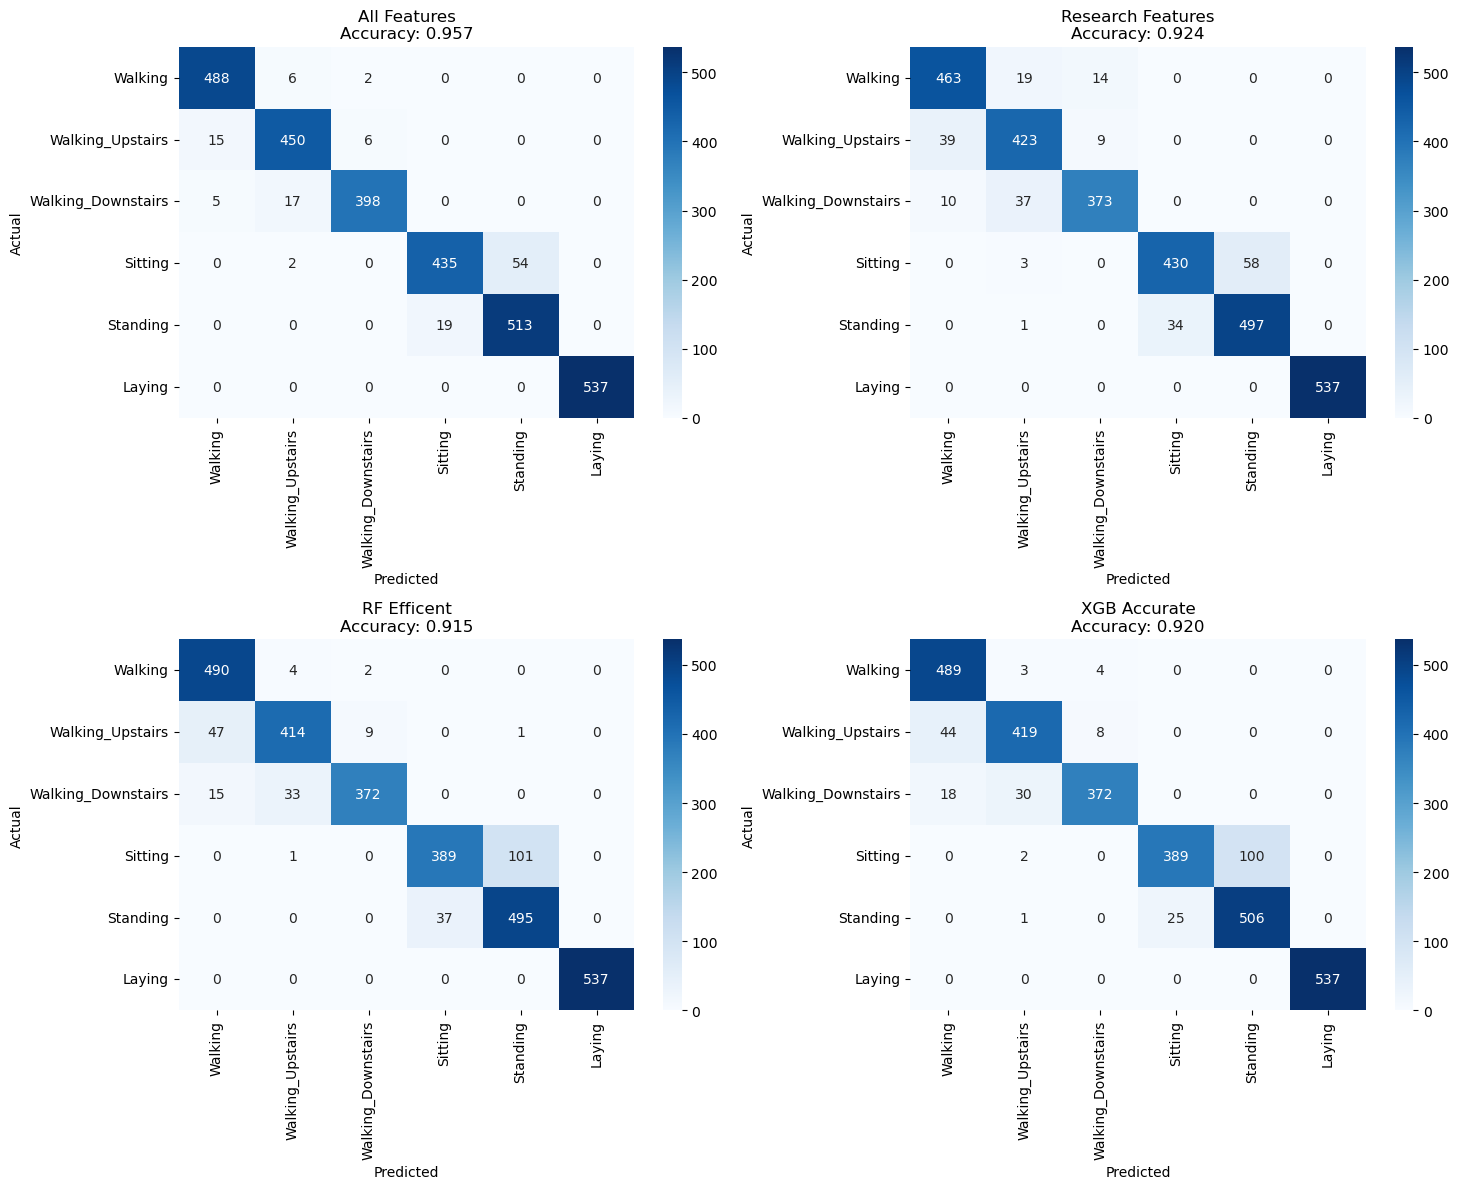

In [109]:
create_confusion_matrices(final_trained_models, test_feature_sets, final_test_results)

<h3>Inference from Confusion Matrices</h3>

<ul>
    <li>The most confused categories for all our models are Sitting and Standing, which is understandable. Even humans struggle to classify those two solely based on a few metric like jerk, entropy, gravity etc, which if you take a look is a lot similar for both the categories.</li>
    <li>The category laying is isolated from all the other categories, hence it is easily identifiable.</li>
    <li>The Research Feature set balances the accuracy in identifying all the categories, while the RF efficent and XGB accurate set Sitting prediction is off by a large margin comapred to other categories.</li>

<h3>Business Use Case Recommendations</h3>

<h4>What feature set should we use based on the business scenario?</h4>

<ul>
    <li><b>We want a model with the highest accuracy and the resources are abundant: </b> We use the XGBoost model with All Features</li>
    <li><b>We want a high accuracy model and the resources are limited: </b> We use the XGBoost model with XGB Accurate set which is 90% lighter. </li>
    <li><b>We want a model for mobile and IoT applications so the model should be very light and of decent accuracy </b> We use the XGBoost model with RF efficent feature set.</li>
</ul>

<h3>Future Potential</h3>

<ul>
    <li>Identify features responsible for identifying <b>sitting</b> category using various feature combinatin techniques and add them to the RF efficent set to make it more accurate and bring it closer to the baseline performance. Make sure the feature additions do not hurt the other category identification performance (SHAP analysis might help).</li>
    <li>Deploy model of choice based on business scenario on a cloud platform and build and api, so that applications can use this model.</li>
    <li>Use MLops to monnitor performance and drift of the model and also build automatic re-training pipelines.</li>